In [ ]:
!pip install pyLDAvis

In [42]:
#Loading the required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
# *matplotlib* for 2D plots and graphs
import matplotlib.pyplot as plt
import os

#TEXT PROCESSING libs
import re
# *textblob* for textual data processing
from textblob import TextBlob
import logging
import gensim
from gensim import corpora, models, similarities
import tempfile
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models as gensimvis

In [43]:
df = pd.read_csv("firing.csv")
df.columns
df.head(30000)

Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  
0      @SdqJaan ŸæŸàŸÑ€åÿ≥ ŸÜ€í ÿ≠ŸÖŸÑ€Å ÿ¢Ÿàÿ± ⁄©Ÿà AK-47 ⁄©€í ÿ≥ÿßÿ™⁄æ ⁄©€å...  
1      BLACK DAY FOR PAKISTANüò≠üò≠ #Firing #ImranKhan #ÿπ...  
2      Imran Khan himself has created this drama to e...  
3      Shooter details*   Name: General Qamar Javed B...  
4      Only Army Bajwa's bastards are behind him. Fuc...  
...                                                  ...  
24007  Wondering about Firing incident on PTI dharna ...  
24008  Will Rana sanaullah be accountable for what he...  
24009  @GFarooqi Abay aur firing papian dene ke liye ...  
24010  €î ŸÑÿßŸÜ⁄Ø ŸÖÿßÿ±⁄Ü ŸÖ€å⁄∫ ÿ®€Åÿ™ ÿ≥€å ÿßŸÜÿ≥ÿßŸÜ€å ÿ¨ÿßŸÜŸà⁄∫ ⁄©ÿß ŸÜŸÇÿµÿßŸÜ €Å...  
24011  Saw the devastated news!!! I hope he's safe an...  

[24012 rows x 3 columns]

In [44]:
##Preprocessing the dataset for Formatting and Duplicacies

# Lowercase 
df['tweet']=df['tweet'].str.lower()
df.head(25000)

Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  
0      @sdqjaan ŸæŸàŸÑ€åÿ≥ ŸÜ€í ÿ≠ŸÖŸÑ€Å ÿ¢Ÿàÿ± ⁄©Ÿà ak-47 ⁄©€í ÿ≥ÿßÿ™⁄æ ⁄©€å...  
1      black day for pakistanüò≠üò≠ #firing #imrankhan #ÿπ...  
2      imran khan himself has created this drama to e...  
3      shooter details*   name: general qamar javed b...  
4      only army bajwa's bastards are behind him. fuc...  
...                                                  ...  
24007  wondering about firing incident on pti dharna ...  
24008  will rana sanaullah be accountable for what he...  
24009  @gfarooqi abay aur firing papian dene ke liye ...  
24010  €î ŸÑÿßŸÜ⁄Ø ŸÖÿßÿ±⁄Ü ŸÖ€å⁄∫ ÿ®€Åÿ™ ÿ≥€å ÿßŸÜÿ≥ÿßŸÜ€å ÿ¨ÿßŸÜŸà⁄∫ ⁄©ÿß ŸÜŸÇÿµÿßŸÜ €Å...  
24011  saw the devastated news!!! i hope he's safe an...  

[24012 rows x 3 columns]

In [45]:
# Removing twitter user id's mentioned in the tweets
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['tweet'] = df['tweet'].apply(remove_twitter_ids)
df.head(30000)

Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  
0                     ak47 imrankhan firing ptilongmarch  
1               black day for pakistan firing imrankhan   
2      imran khan himself has created this drama to e...  
3      shooter details name general qamar javed bajwa...  
4      only army bajwas bastards are behind him fuck ...  
...                                                  ...  
24007  wondering about firing incident on pti dharna ...  
24008  will rana sanaullah be accountable for what he...  
24009   abay aur firing papian dene ke liye karte hai...  
24010                               firing coas genbajwa  
24011  saw the devastated news i hope hes safe and ev...  

[24012 rows x 3 columns]

In [46]:
# Duplicate tweet count
duplicate_count = len(df['tweet'])-len(df['tweet'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 15244
total records before remove duplicates: 24012


In [47]:
# Drop duplicates (keeping the last tweet of each of the duplicates)
df_Coles = df.drop_duplicates(subset='tweet', keep="last")
print('updated record count:', df.shape[0])

updated record count: 24012


In [48]:
# Removing punctuatuions
df['tweet'] = df['tweet'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.head(30000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  
0                     ak47 imrankhan firing ptilongmarch  
1               black day for pakistan firing imrankhan   
2      imran khan himself has created this drama to e...  
3      shooter details name general qamar javed bajwa...  
4      only army bajwas bastards are behind him fuck ...  
...                                                  ...  
24007  wondering about firing incident on pti dharna ...  
24008  will rana sanaullah be accountable for what he...  
24009   abay aur firing papian dene ke liye karte hai...  
24010                               firing coas genbajwa  
24011  saw the devastated news i hope hes safe and ev...  

[24012 rows x 3 columns]

In [49]:
# Load NLTK library
#Langauage processing libraries
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# get the list of all stopwords from the library (Language - 'en')
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [51]:
stop.remove('not')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [53]:
# Removing the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['tweet'] = df['tweet'].apply(remove_stop_words)
df.head(30000)


Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  
0                     ak47 imrankhan firing ptilongmarch  
1                    black day pakistan firing imrankhan  
2      imran khan created drama end long march confid...  
3      shooter details name general qamar javed bajwa...  
4      army bajwas bastards behind fuck bajwa company...  
...                                                  ...  
24007  wondering firing incident pti dharna punjab go...  
24008  rana sanaullah accountable said earlier would ...  
24009  abay aur firing papian dene ke liye karte hain...  
24010                               firing coas genbajwa  
24011  saw devastated news hope hes safe everyone aro...  

[24012 rows x 3 columns]

In [54]:
##Standardization of tweets using NLTK Library

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['tweet_stem'] = df['tweet'].apply(stemming_function)

In [55]:
# Compare the content vs. stemmed content
df[['tweet', 'tweet_stem']].head(25000)

tweet  \
0                     ak47 imrankhan firing ptilongmarch   
1                    black day pakistan firing imrankhan   
2      imran khan created drama end long march confid...   
3      shooter details name general qamar javed bajwa...   
4      army bajwas bastards behind fuck bajwa company...   
...                                                  ...   
24007  wondering firing incident pti dharna punjab go...   
24008  rana sanaullah accountable said earlier would ...   
24009  abay aur firing papian dene ke liye karte hain...   
24010                               firing coas genbajwa   
24011  saw devastated news hope hes safe everyone aro...   

                                              tweet_stem  
0                       ak47 imrankhan fire ptilongmarch  
1                      black day pakistan fire imrankhan  
2      imran khan creat drama end long march confiden...  
3      shooter detail name gener qamar jave bajwa arr...  
4      armi bajwa bastard behind fuck bajwa compani i...  
...                                                  ...  
24007  wonder fire incid pti dharna punjab govtbelong...  
24008  rana sanaullah account said earlier would go p...  
24009  abay aur fire papian dene ke liy kart hain aje...  
24010                                  fire coa genbajwa  
24011  saw devast news hope he safe everyon around go...  

[24012 rows x 2 columns]

In [57]:
##WORD FREQUENCY ANALYSIS

# Creating a word frequency series
#(This is a **pandas** series)
word_frequency = pd.Series(' '.join(df['tweet']).split()).value_counts()

In [62]:
# Display top 10 words
word_frequency[:10]

firing                 25015
imrankhan               9933
khan                    5134
imran                   4887
pakistan                2378
imrankhanourredline     2133
allah                   2107
imrankhanlongmarch      2040
imrankhanpti            1855
pti                     1699
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


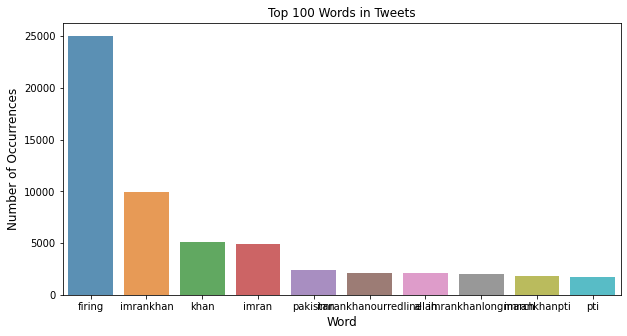

In [63]:
# Visualizing the top 10 word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Top 100 Words in Tweets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

In [64]:
from PIL import Image
from wordcloud import WordCloud

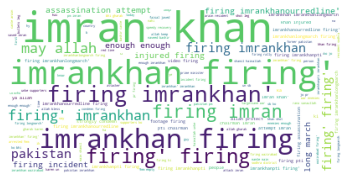

In [67]:
#Visualizing text corpus
corpus = list(df['tweet'])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [68]:
##BIGRAMS

#Extracting Bigrams from the tweet dataset
#This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [69]:
bigrams_tweets = get_ngrams(df['tweet'].tolist(), ngram_range=(2, 2))

In [70]:
#Converting bigram to a dataframe with column names bi-gram and frequency.
bigrams_tweets_df = pd.DataFrame(bigrams_tweets)
bigrams_tweets_df.columns=["Bigrams", "Freqency"]

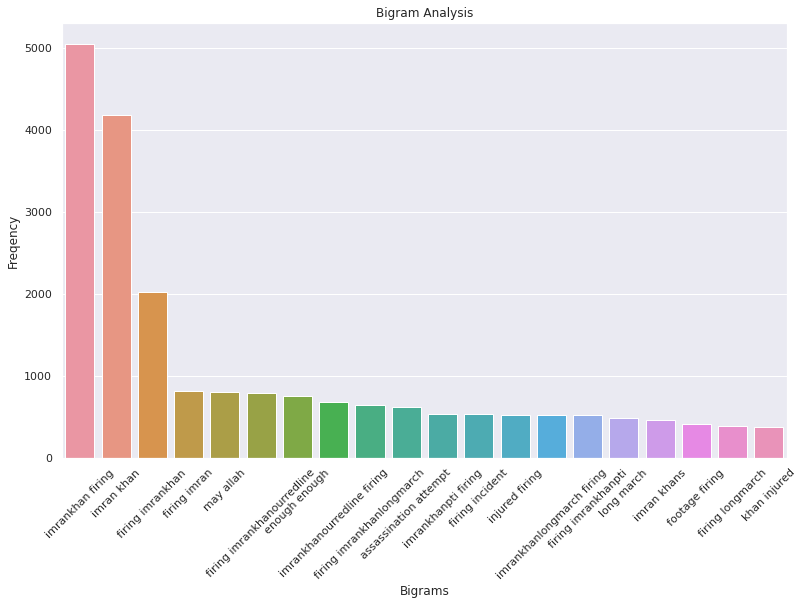

In [73]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bigrams", y="Freqency", data=bigrams_tweets_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Bigram Analysis')
plt.show()

In [74]:
# Trigrams
#Most frequently occuring Tri-grams
def get_trigrams(corpus):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

trigrams_tweets = get_ngrams(df['tweet'].tolist(), ngram_range=(3, 3))

In [75]:
#Converting tri-gram of dataset to a dataframe with column names tri-gram and frequency.
trigrams_tweets_df = pd.DataFrame(trigrams_tweets)
trigrams_tweets_df.columns=["Trigrams", "Freqency"]

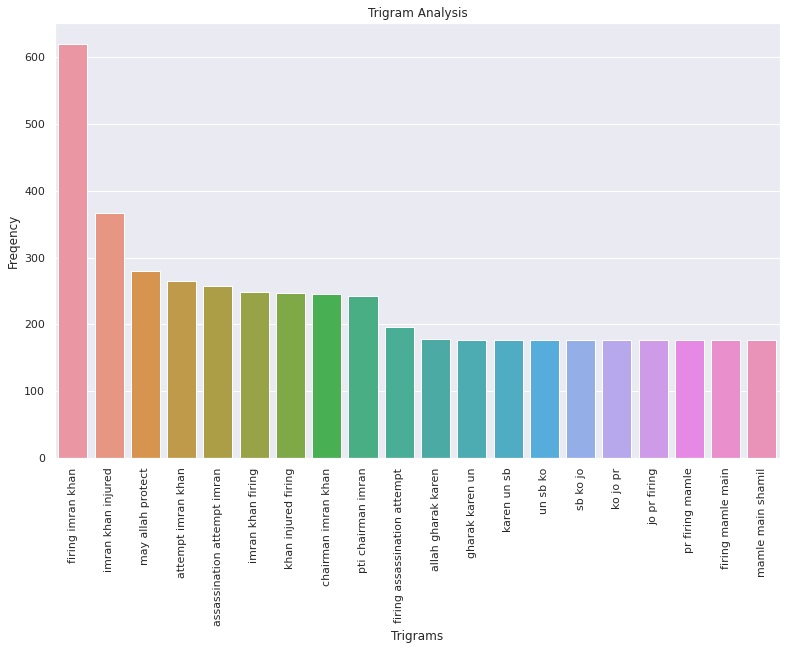

In [76]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Trigrams", y="Freqency", data=trigrams_tweets_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Trigram Analysis')
plt.show()

In [78]:
# Group the twitter dataset based on the date field and get the count per each day.
df_date_wise = df.groupby(['date'])['tweet'].count().reset_index(name='tweet_count').set_index('date')

#Display top n 
df_date_wise.head(5)

tweet_count
date                   
2022-11-03        24012

In [83]:
#Text Blob (Data Labeling)

def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity

def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity

#creating two columns subjectivity and polarity

df['Subjectivity'] = df['tweet'].apply(getSubjectivity)
df['Polarity'] = df['tweet'].apply(getPolarity)

df.head(25000)

Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  \
0                     ak47 imrankhan firing ptilongmarch   
1                    black day pakistan firing imrankhan   
2      imran khan created drama end long march confid...   
3      shooter details name general qamar javed bajwa...   
4      army bajwas bastards behind fuck bajwa company...   
...                                                  ...   
24007  wondering firing incident pti dharna punjab go...   
24008  rana sanaullah accountable said earlier would ...   
24009  abay aur firing papian dene ke liye karte hain...   
24010                               firing coas genbajwa   
24011  saw devastated news hope hes safe everyone aro...   

                                              tweet_stem  sentiment  \
0                       ak47 imrankhan fire ptilongmarch   0.000000   
1                      black day pakistan fire imrankhan  -0.166667   
2      imran khan creat drama end long march confiden...  -0.050000   
3      shooter detail name gener qamar jave bajwa arr...  -0.025000   
4      armi bajwa bastard behind fuck bajwa compani i...  -0.400000   
...                                                  ...        ...   
24007  wonder fire incid pti dharna punjab govtbelong...   0.000000   
24008  rana sanaullah account said earlier would go p...   0.000000   
24009  abay aur fire papian dene ke liy kart hain aje...   0.000000   
24010                                  fire coa genbajwa   0.000000   
24011  saw devast news hope he safe everyon around go...   0.366667   

       Subjectivity  Polarity  
0          0.000000  0.000000  
1          0.433333 -0.166667  
2          0.400000 -0.050000  
3          0.500000 -0.025000  
4          0.650000 -0.400000  
...             ...       ...  
24007      0.000000  0.000000  
24008      0.241667  0.000000  
24009      0.000000  0.000000  
24010      0.000000  0.000000  
24011      0.500000  0.366667  

[24012 rows x 7 columns]

In [84]:
#creating a function for sentiment text

def getSentiment(score):
  if score < 0:
    return 'Negative'

  elif score == 0:
    return 'Netural'

  elif score > 0:
    return 'Positive'

In [86]:
df['Sentiment'] = df['Polarity'].apply(getSentiment)

df.head(25000)

Unnamed: 0        date  \
0               0  2022-11-03   
1               1  2022-11-03   
2               2  2022-11-03   
3               3  2022-11-03   
4               4  2022-11-03   
...           ...         ...   
24007       24007  2022-11-03   
24008       24008  2022-11-03   
24009       24009  2022-11-03   
24010       24010  2022-11-03   
24011       24011  2022-11-03   

                                                   tweet  \
0                     ak47 imrankhan firing ptilongmarch   
1                    black day pakistan firing imrankhan   
2      imran khan created drama end long march confid...   
3      shooter details name general qamar javed bajwa...   
4      army bajwas bastards behind fuck bajwa company...   
...                                                  ...   
24007  wondering firing incident pti dharna punjab go...   
24008  rana sanaullah accountable said earlier would ...   
24009  abay aur firing papian dene ke liye karte hain...   
24010                               firing coas genbajwa   
24011  saw devastated news hope hes safe everyone aro...   

                                              tweet_stem  sentiment  \
0                       ak47 imrankhan fire ptilongmarch   0.000000   
1                      black day pakistan fire imrankhan  -0.166667   
2      imran khan creat drama end long march confiden...  -0.050000   
3      shooter detail name gener qamar jave bajwa arr...  -0.025000   
4      armi bajwa bastard behind fuck bajwa compani i...  -0.400000   
...                                                  ...        ...   
24007  wonder fire incid pti dharna punjab govtbelong...   0.000000   
24008  rana sanaullah account said earlier would go p...   0.000000   
24009  abay aur fire papian dene ke liy kart hain aje...   0.000000   
24010                                  fire coa genbajwa   0.000000   
24011  saw devast news hope he safe everyon around go...   0.366667   

       Subjectivity  Polarity Sentiment  
0          0.000000  0.000000   Netural  
1          0.433333 -0.166667  Negative  
2          0.400000 -0.050000  Negative  
3          0.500000 -0.025000  Negative  
4          0.650000 -0.400000  Negative  
...             ...       ...       ...  
24007      0.000000  0.000000   Netural  
24008      0.241667  0.000000   Netural  
24009      0.000000  0.000000   Netural  
24010      0.000000  0.000000   Netural  
24011      0.500000  0.366667  Positive  

[24012 rows x 8 columns]

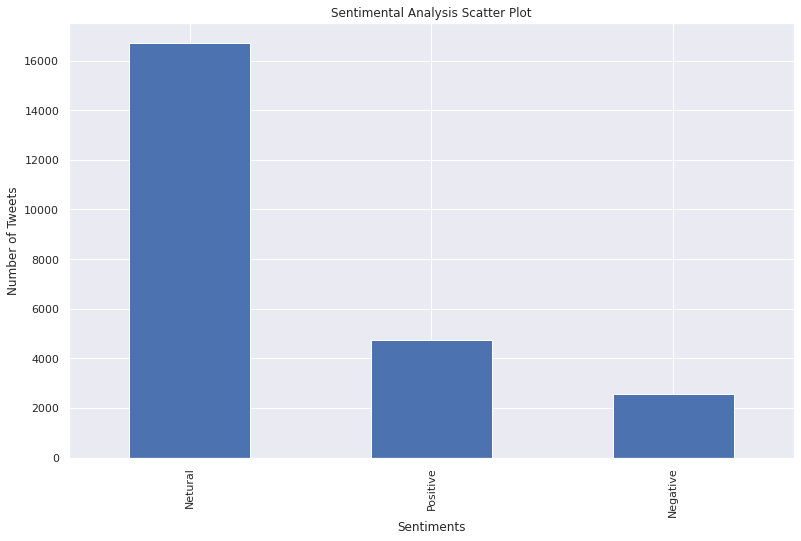

In [88]:
df['Sentiment'].value_counts().plot(kind= 'bar')
plt.title('Sentimental Analysis Scatter Plot')
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

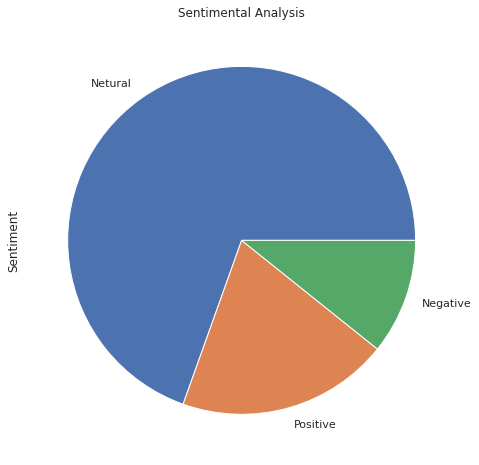

In [90]:
df['Sentiment'].value_counts().plot(kind= 'pie')
plt.title('Sentimental Analysis')
plt.show()

In [91]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vectorize = CountVectorizer() 
vectorized = count_vectorize.fit_transform(df["tweet"])

In [101]:
print(vectorized[0,:])

#print(vc.vocabulary_)
print(count_vectorize.get_feature_names_out())
print(count_vectorize.get_feature_names_out()[14174], vectorized[0,14174])

  (0, 637)	1
  (0, 6073)	1
  (0, 4454)	1
  (0, 10407)	1
['0005' '009' '0099' ... 'zyada' 'zyadti' 'zyda']
zyda 0


In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,df["Sentiment"],test_size = 0.2, random_state =26105111)

In [105]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

MultinomialNB()

In [106]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [107]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.8965230064542994

Text(238.76, 0.5, 'predicted label')

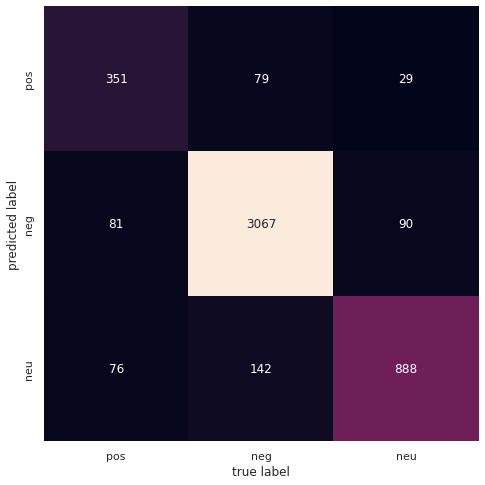

In [108]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [113]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

BernoulliNB()

In [114]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [115]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.8552987716010827

Text(238.76, 0.5, 'predicted label')

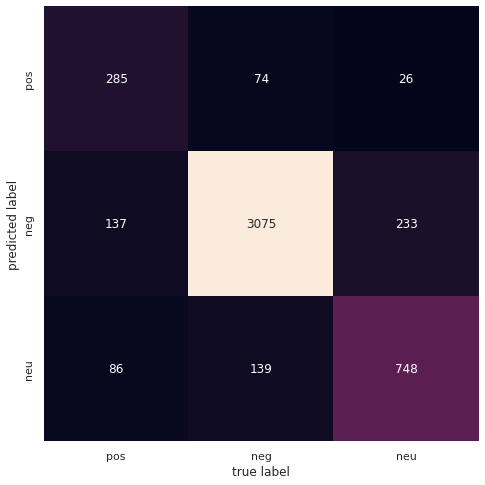

In [116]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [121]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
vectorized = count_vectorize.fit_transform(X_train["tweet"])
logisticRegr.fit(vectorized, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [122]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [123]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.8552987716010827

Text(238.76, 0.5, 'predicted label')

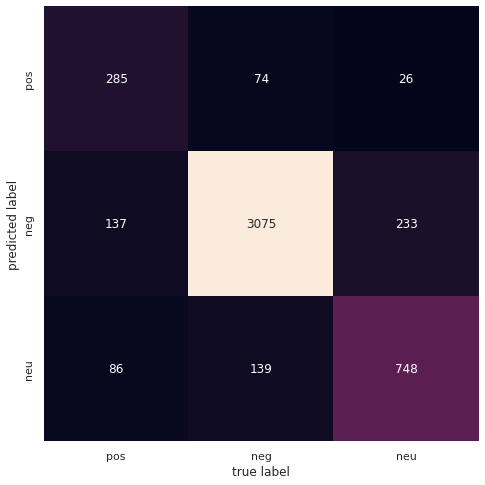

In [124]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [125]:
from sklearn.svm import LinearSVC
clf=LinearSVC()
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [126]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [127]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)


0.9843847595252967

Text(238.76, 0.5, 'predicted label')

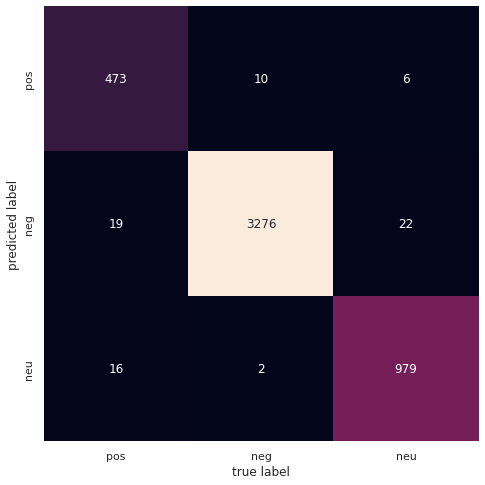

In [128]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [130]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [131]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [132]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.909015198834062

Text(238.76, 0.5, 'predicted label')

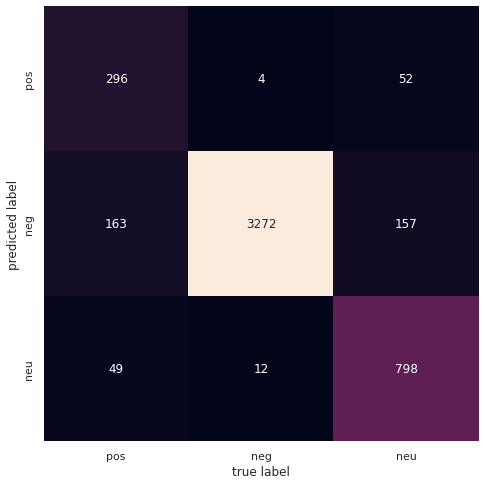

In [133]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [135]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier()
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

RidgeClassifier()

In [136]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [137]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.9752238184468041

Text(238.76, 0.5, 'predicted label')

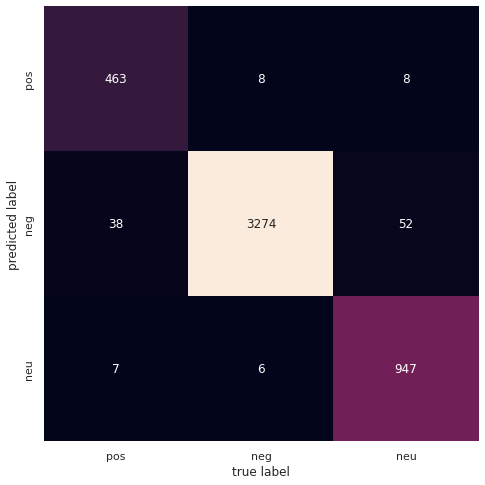

In [138]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [139]:
from sklearn.linear_model import PassiveAggressiveClassifier
clf = PassiveAggressiveClassifier(random_state=0)
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

PassiveAggressiveClassifier(random_state=0)

In [140]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [141]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.982927337080991

Text(238.76, 0.5, 'predicted label')

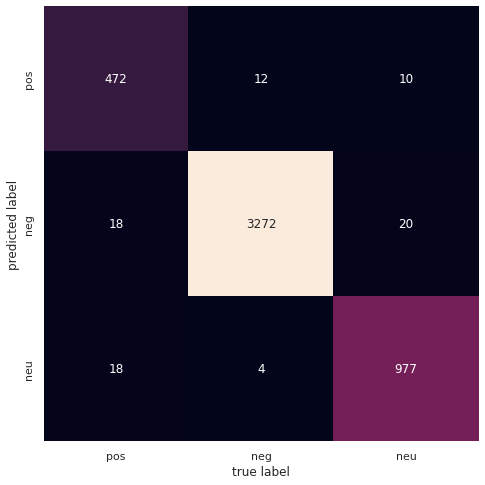

In [142]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [143]:
from sklearn.linear_model import Perceptron
clf = Perceptron(random_state=0)
vectorized = count_vectorize.fit_transform(X_train["tweet"])
clf.fit(vectorized, y_train)

Perceptron()

In [144]:
vectorized = count_vectorize.transform(X_test["tweet"])
res=clf.predict(vectorized)

In [145]:
from sklearn import metrics
metrics.accuracy_score(res, y_test)

0.9808453050176973

Text(238.76, 0.5, 'predicted label')

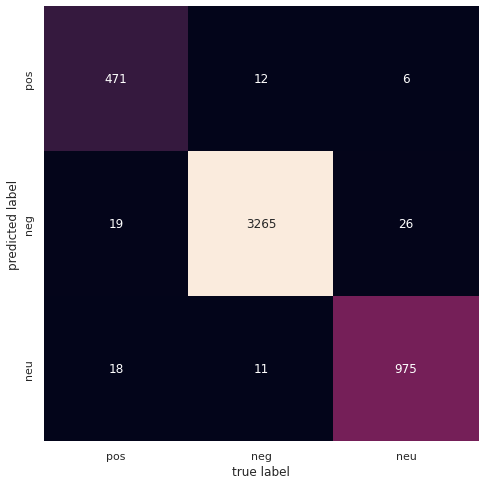

In [146]:
mat = confusion_matrix(y_test, res)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["pos","neg","neu"], yticklabels=["pos","neg","neu"])
plt.xlabel('true label')
plt.ylabel('predicted label')